In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import matplotlib
import controlled_traj, utils, rates
from utils import Ruggedmueller2

import math
pitorch = torch.Tensor([math.pi])

In [2]:
FD_file = pd.read_excel('./data/test_data_T10.xlsx')

test_x = pd.DataFrame(FD_file['X'])
test_y = pd.DataFrame(FD_file['Y'])
target = pd.DataFrame(FD_file['committor'])
target_np = np.array(target.values)

X_10 = torch.tensor(test_x.values,dtype=torch.float32)
Y_10 = torch.tensor(test_y.values,dtype=torch.float32)
Q_fem_10 = torch.tensor(target.values,dtype = torch.float32)

test_data_10 = torch.cat((X_10,Y_10), 1)
test_data_10.requires_grad = (True)

In [3]:
# calculate the normalization number
U_10 = utils.funU(test_data_10[:,0],test_data_10[:,1])
Z_10 = torch.sum(Q_fem_10*(1-Q_fem_10)*torch.exp(-(1/10)*U_10)[:,None])
mR_10 = Q_fem_10*(1-Q_fem_10)*torch.exp(-(1/10)*U_10)[:,None]/Z_10

In [4]:
model_d_net_T10 = torch.load('./data/d-net_T10_2hidden40.pt')
model_d_net_T10.eval()

df = pd.read_excel('./data/traindata_meta_delta-net_T10.xlsx')

X_train = pd.DataFrame(df['X'])
Y_train = pd.DataFrame(df['Y'])

X_train = torch.tensor(X_train.values,dtype=torch.float32)
Y_train = torch.tensor(Y_train.values,dtype=torch.float32)

train_data = torch.cat((X_train, Y_train), 1)

The wMAE of uniform in space when T = 10 is 0.0026421, and wRMSE is 0.0041328


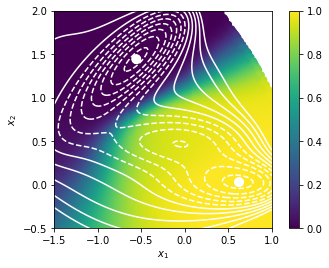

In [5]:
# Temperature 10
chia_t,chib_t = utils.chiAB(test_data_10)
chia_t_train, chib_t_train = utils.chiAB(train_data)

q_tilde_T10_dnet = model_d_net_T10(test_data_10)
Q_T10_dnet = utils.q_theta(test_data_10,chia_t,chib_t,q_tilde_T10_dnet)

q_tilde_T10_dnet_train = model_d_net_T10(train_data)
Q_T10_dnet_train = utils.q_theta(train_data,chia_t_train,chib_t_train,q_tilde_T10_dnet_train)

diff_10_dnet = torch.abs(Q_fem_10 - Q_T10_dnet)
MAE_10_dnet = torch.sum(mR_10*diff_10_dnet)
RMSE_10_dnet = torch.sqrt(torch.sum(mR_10*diff_10_dnet.pow(2)))
print('The wMAE of uniform in space when T = 10 is {:.5}, and wRMSE is {:.5}'.format(MAE_10_dnet,RMSE_10_dnet))

import matplotlib.pyplot as plt

x = np.linspace(-1.5,1,1000)
y = np.linspace(-1.5,2.5,1000)
xx,yy = np.meshgrid(x,y)
A = utils.funU(torch.tensor(xx),torch.tensor(yy))

plt.contour(xx,yy,A.detach().numpy(),colors='white',levels = np.arange(-200,100,20), linewidths = 1.5)

plt.scatter(test_data_10[:,0].detach().numpy(),test_data_10[:,1].detach().numpy(),\
            c = Q_fem_10.detach().numpy())
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
ax = plt.gca()
# plt.axis('equal')
plt.xlim([-1.5,1])
plt.ylim([-0.5,2])
ax.set_aspect(1)
# plt.savefig('MuellerFEMcomm10.pdf')
plt.show()


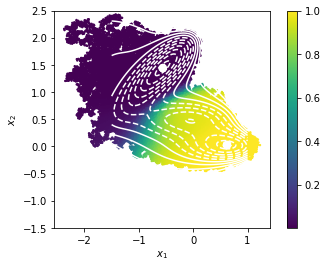

In [6]:
plt.contour(xx,yy,A.detach().numpy(),colors='white',levels = np.arange(-200,100,20),linewidths = 1.5)

plt.scatter(X_train.detach().numpy(),Y_train.detach().numpy(),\
            c = Q_T10_dnet_train.detach().numpy(),s = 2)
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.axis('equal')
# matplotlib.axes.Axes.set_xlim([-1.5, 1])
ax = plt.gca()
# ax.set_xlim([-1.5, 1])
# ax.set_ylim([-0.5, 2])
ax.set_aspect(1)
# plt.xlim([-1.5,1])
# plt.ylim([-0.5,2])
# plt.savefig('MuellerNNcomm10.pdf')
plt.show()